# *Lipomyces starkeyi* medium optimization round 2 - part B.

This notebook leverages ART to identify conditions for testing during a second round of medium optimization. The round was split into two different ART training notebooks - parts A and parts B. This is **part B**.

Medium components have a profound impact on production of microbial products. The effects of metals and vitamins on *L. starkeyi* malic acid production has been explored in a limited capacity - with the full composition space remaining to be explored. The Automated Recommendation Tool ([ART](https://www.nature.com/articles/s41467-020-18008-4)) is a machine learning based tool for bioproduction applications. The tool has been designed to provide both initial design of experiment and recommendations for further designs. The algorithm uses [Latin Hypercube Sampling](https://en.wikipedia.org/wiki/Latin_hypercube_sampling) to combinatorally explore the initial design space. A media optimization pipeline has been described using ART ([Zournas A et al., 2024: DOI: 10.21203/rs.3.rs-5072705/v1](https://www.researchsquare.com/article/rs-5072705/v1) that is leveraged here. 

This notebook leverages ART to identify additional explore conditions for testing during a second round of medium optimization. The notebook uses the DBTL1 and DBTL2 conditions (NOT results) to train a model, and then uses the newly trained model for exploration of the medium space.

## Inputs and Outputs

**Required files to run this notebook:**
- `bounds_file_DBTL2.csv` - Contains the boundaries to explore.
- `standard_media_file.csv` - Contains the medium components.
- `combinedResults_DBTL1and2.csv` - Round 1 results and round 2 conditions/data.

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import sys
sys.path.append('../../AutomatedRecommendationTool')        # Make sure this is the location for the ART library 
sys.path.append('../')

import re
import warnings

import matplotlib.pyplot as plt
# from art.core import designs_pairwise/
from art.core import * 
import art.plot as plot
import edd_utils as eddu

import os


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/usr/local/art/.venv/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
# from art.core import designs_pairwise

# User parameters

In [3]:
CYCLE = 2

user_params = {
    # file containing the lower and upper bounds to explore. 
    #'bounds_file': f'mediumSetup/bounds_file.csv',
    'bounds_file': f'mediumSetup/bounds_file_DBTL2.csv',

    
    
    # folder for output files.
    'output_file_path': f'mediumConcentrationOutputs/DBTL_2_partB_explore{CYCLE}', 
    
    # folder containing the standard media file. 
    # for Lipomyces - this is the LPM-40-50 (lipid production medium - 40 g carbon, 50 C/N ratio).
    'standard_media_file': f'mediumSetup/standard_media_file.csv',
    
    
}

In [4]:
user_params['components'] = [
        #'glucose',
        #'xylose',
        'KH2PO4',
        'NH4Cl',
        'KCl',
        'MgSO4*7H2O',
        'ZnSO4·7H2O',
        'H3BO3',
        'MnCl2·4H2O',
        'FeSO4·7H2O',
        'CoCl2·6H2O',
        'CuSO4·5H20',
        'Na2MoO4·2H2O',
        'Na4EDTA',
        'biotin',
        'pyridoxine',
        'thiamine',
        'riboflavin',
        'para-aminobenzoic acid',
        'nicotinic acid'
]

In [5]:
user_params['response'] = 'Malate Titer (g/L)'

# Load the data

In [6]:
DBTL_results = pd.read_csv('experimentalResults/DBTL2_results/dummyResults_DBTL1and2.csv')
DBTL_results.rename(columns={'Unnamed: 0': 'Line Name'},inplace=True)

# col_drop = np.arange(0,75) # drop all except control from dbtl 1a
# DBTL1_results.drop(col_drop,inplace=True)
DBTL_results.tail(4)

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L)
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# add the replicate indicator (Replicate 1 = -R1, Replicate 2 = '-R2', etc) to each line name.

DBTL_results['Line Name'][0::3] = DBTL_results['Line Name'][0::3].astype(str)+'-R1'
DBTL_results['Line Name'][1::3] = DBTL_results['Line Name'][1::3].astype(str)+'-R2'
DBTL_results['Line Name'][2::3] = DBTL_results['Line Name'][2::3].astype(str)+'-R3'

/tmp/ipykernel_47872/2375468345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DBTL_results['Line Name'][0::3] = DBTL_results['Line Name'][0::3].astype(str)+'-R1'
/tmp/ipykernel_47872/2375468345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DBTL_results['Line Name'][1::3] = DBTL_results['Line Name'][1::3].astype(str)+'-R2'
/tmp/ipykernel_47872/2375468345.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DBTL_results['Line 

In [8]:
DBTL_results.tail(6)

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L)
213,nan-R1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,nan-R2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,nan-R3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
216,nan-R1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,nan-R2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,nan-R3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Define the controls. In DBTL 1 and 2, controls were samples 25. 

In [9]:
# control_lines = DBTL1_results[DBTL1_results['Line Name'].str.find('25')>-1]
control_lines = DBTL_results[DBTL_results['Line Name'].str.find('25a')>-1]
control_lines

,Line Name,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,...,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),DCW (g/L)
75,25a-R1,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,...,0.000085,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10.54,13.780
76,25a-R2,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,...,0.000085,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10.92,12.940
77,25a-R3,1.5,1.43,0.5,0.5,0.00225,0.011,0.005,0.005,0.0017,...,0.000085,0.005,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10.63,17.236


How many designs imporved the response over the standard recipe?

In [10]:
control_response = np.mean(control_lines['Malate Titer (g/L)'])
num_improved_response = np.sum(DBTL_results['Malate Titer (g/L)'] > control_response)
num_designs = len(DBTL_results) - len(control_lines)
print(f'{num_improved_response} samples out of {num_designs} improve over the standard in terms of Titer ({num_improved_response/num_designs*100:.2f})%')

1 samples out of 216 improve over the standard in terms of Titer (0.46)%


## Convert the data to EDD format for ART input.

Pivot the dataframe to [Experimental Data Depot format](https://edd-docs.jbei.org/), inlcuding all components names and protocols:

In [11]:
DBTL_stacked = DBTL_results.set_index('Line Name').stack().reset_index()
DBTL_stacked.columns = ['Line Name', 'Measurement Type', 'Value']
DBTL_stacked.head()

,Line Name,Measurement Type,Value
0,0a-R1,KH2PO4,3.980770
1,0a-R1,NH4Cl,2.726696
2,0a-R1,KCl,3.101909
3,0a-R1,MgSO4*7H2O,3.564820
4,0a-R1,ZnSO4·7H2O,0.342065


In [12]:
# DBTL_stacked.csv('DBTL1&2EDDformatedResults.csv')

# Media designs recommendations

## ART parameter setup

Define a dictionary that contains the settings ART will use to find the recommended designs:


In [13]:
art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds_file': user_params['bounds_file'], # file with bounds for input variables (i.e., features)
    'seed': 12,
    'cross_val': True,
    'recommend': False,
    'output_directory': user_params['output_file_path'],
    'verbose': 0,
    'max_mcmc_cores':4
}

We will first run only the model building part and then proceed with optimization using the two modes - exploration and explotation.

In [14]:
user_params['alpha_explor'] = 1.0
user_params['alpha_exploit'] = None

Here we specify how many instances (design) we want to create and how many replicates:


In [15]:
user_params['n_instances_explore'] = 10
user_params['n_instances_exploit'] = 13
user_params['n_replicates'] = 3

with the configuration now stored in art_params, we now run ART:

## Initialize and Train ART

In [16]:
run_art = True

Dataframe does not have a time column matching one of the supported formats. Assuming that all data in the file comes from a single time point.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 24 seconds.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.6851452653595517, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampli

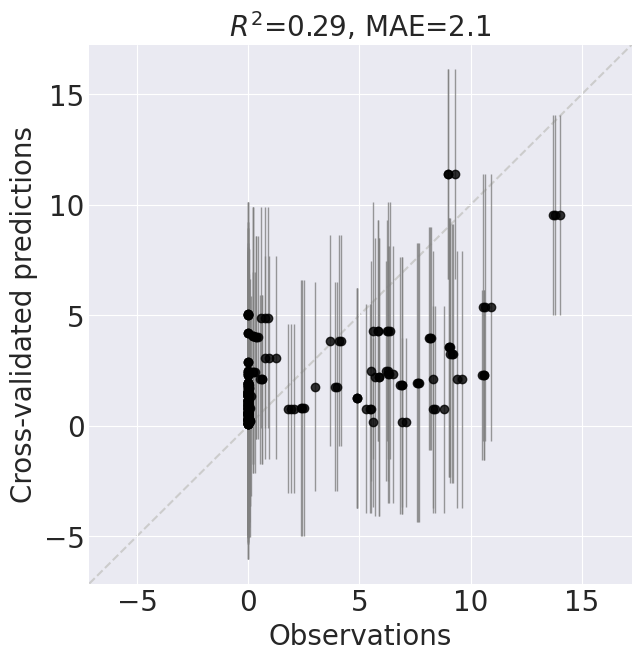

Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omegas, sigma]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.


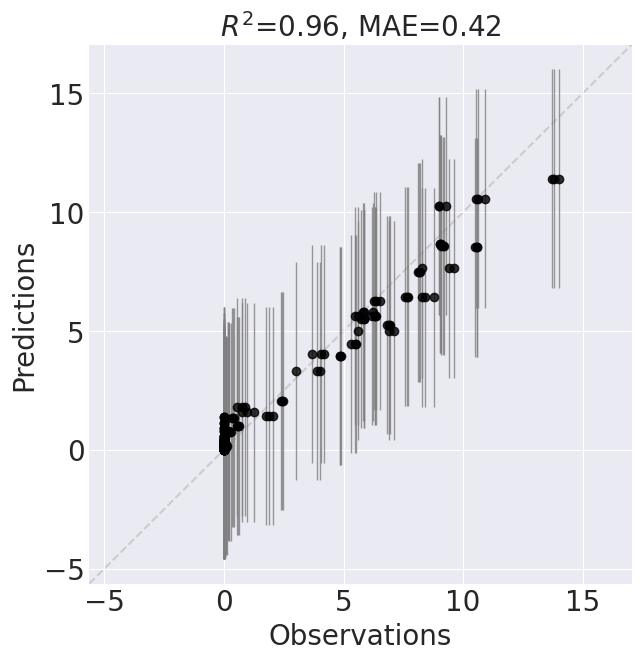

CPU times: user 19min 43s, sys: 8.7 s, total: 19min 52s
Wall time: 22min 53s


In [17]:
%%time
warnings.filterwarnings("ignore")
if run_art:
    art = RecommendationEngine(DBTL_stacked, **art_params)
else:
    with open(os.path.join(art_params['output_directory'], 'art.pkl'), 'rb') as output:
        art = pickle.load(output)

In [18]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,2.109653,inf,2.294874,9.717083,0.155413
Random Forest Regressor,1.975342,inf,2.044709,8.082810,0.297460
Support Vector Regressor,1.892448,inf,2.280636,8.782662,0.236631
Kernel Ridge Regressor,1.796879,inf,1.954200,7.047670,0.387432
K-NN Regressor,2.107088,NaN,2.516134,10.770751,0.063831
Gaussian Process Regressor,2.553952,inf,1.609867,9.114341,0.207802
Gradient Boosting Regressor,2.025565,inf,2.237182,9.107895,0.208362
TPOT Regressor,2.303989,inf,2.157308,9.962341,0.134096
Ensemble Model,2.096149,inf,1.939729,8.156392,0.291065


## Exploration recommendations

In [19]:


%%time
art.niter = 100000
art.alpha = user_params['alpha_explor']
draws = art.parallel_tempering_opt()



CPU times: user 209 ms, sys: 26.2 ms, total: 235 ms
Wall time: 5min 45s


In [21]:
orig_file_name = f"{art_params['output_directory']}/draws.txt"
new_file_name = f"{art_params['output_directory']}/draws_explor.txt"
os.rename(orig_file_name, new_file_name)



In [22]:
art.num_recommendations = user_params['n_instances_explore']
art.rel_rec_distance = 3.0
art.recommend(draws)

# At least one of the features in the recommendation must differ by this relative factor from any point in the training data and any previous recommendations
# Then pick the one with the best objective function value and add to the recommendations. Repeat the distance filtering above. 
# Stops when 7 recommendations are found.

# If it cannot find enough recommendations, it will decrease the distance by 0.80x and try again.

In [23]:
df_rec_explor = art.recommendations.copy()

In [24]:
df_rec_explor

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,Na2MoO4·2H2O,Na4EDTA,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L)
0,3.828675,0.621465,1.240994,1.041451,0.113488,0.054703,0.341223,0.429727,0.054993,0.251498,0.078664,2.092805,0.002969,0.003889,0.008375,0.065605,0.009325,0.007980,5.112985
1,1.872974,1.103961,1.484179,2.775847,0.129709,0.532009,0.182700,0.284566,0.260027,0.314928,0.019919,1.689446,0.007108,0.004857,0.005402,0.041946,0.008686,0.007852,2.110124
2,2.871420,1.975759,0.523162,2.511222,0.171924,0.687266,0.126149,0.466855,0.365200,0.016180,0.084874,1.474078,0.006157,0.003679,0.009884,0.055900,0.004774,0.006202,1.366781
3,4.602384,2.896720,0.703066,0.303343,0.236912,0.205924,0.014042,0.415415,0.355167,0.209686,0.089146,2.119573,0.009649,0.003933,0.008269,0.046671,0.007640,0.005537,3.063016
4,1.958004,1.959630,1.019778,2.897484,0.196985,0.603512,0.143532,0.444478,0.307528,0.110614,0.098844,2.061858,0.007607,0.004181,0.007204,0.061299,0.006812,0.008468,1.467233
5,1.965494,3.273739,4.333824,0.645869,0.168718,0.046540,0.109407,0.432857,0.025236,0.020338,0.098555,2.352664,0.004187,0.009322,0.007283,0.021963,0.009891,0.003722,3.557785
6,4.372539,4.381191,0.506900,2.133481,0.176888,0.164310,0.199915,0.393089,0.053136,0.452417,0.089538,2.283549,0.001426,0.003180,0.000741,0.053451,0.004816,0.009219,2.535037
7,1.009964,4.731832,4.890619,2.759800,0.363581,0.471889,0.002918,0.276033,0.410649,0.107661,0.046804,1.342612,0.008326,0.007475,0.000381,0.048153,0.008718,0.009584,1.186013
8,1.351364,3.567268,4.515219,0.005451,0.184499,0.068868,0.115610,0.489477,0.037269,0.084061,0.089799,2.187609,0.005245,0.008421,0.004221,0.024498,0.009328,0.004288,3.253610
9,4.433752,4.694351,4.238639,3.260032,0.100750,0.205516,0.350869,0.291598,0.197136,0.068449,0.079552,1.343029,0.007067,0.009720,0.005948,0.049676,0.009575,0.006807,2.684709


In [25]:
predicted_mean, predicted_std = art.post_pred_stats(
            df_rec_explor.values[:, :-1]
        )
df_rec_explor['Malate Titer (g/L) mean'] = predicted_mean
df_rec_explor['Malate Titer (g/L) std'] = predicted_std

df_rec_explor['Label'] = 'exploration'

In [26]:
df_rec_explor

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,3.828675,0.621465,1.240994,1.041451,0.113488,0.054703,0.341223,0.429727,0.054993,0.251498,...,0.002969,0.003889,0.008375,0.065605,0.009325,0.007980,5.112985,5.112985,2.406545,exploration
1,1.872974,1.103961,1.484179,2.775847,0.129709,0.532009,0.182700,0.284566,0.260027,0.314928,...,0.007108,0.004857,0.005402,0.041946,0.008686,0.007852,2.110124,2.110124,2.399036,exploration
2,2.871420,1.975759,0.523162,2.511222,0.171924,0.687266,0.126149,0.466855,0.365200,0.016180,...,0.006157,0.003679,0.009884,0.055900,0.004774,0.006202,1.366781,1.366781,2.389498,exploration
3,4.602384,2.896720,0.703066,0.303343,0.236912,0.205924,0.014042,0.415415,0.355167,0.209686,...,0.009649,0.003933,0.008269,0.046671,0.007640,0.005537,3.063016,3.063016,2.388037,exploration
4,1.958004,1.959630,1.019778,2.897484,0.196985,0.603512,0.143532,0.444478,0.307528,0.110614,...,0.007607,0.004181,0.007204,0.061299,0.006812,0.008468,1.467233,1.467233,2.387376,exploration
5,1.965494,3.273739,4.333824,0.645869,0.168718,0.046540,0.109407,0.432857,0.025236,0.020338,...,0.004187,0.009322,0.007283,0.021963,0.009891,0.003722,3.557785,3.557785,2.364728,exploration
6,4.372539,4.381191,0.506900,2.133481,0.176888,0.164310,0.199915,0.393089,0.053136,0.452417,...,0.001426,0.003180,0.000741,0.053451,0.004816,0.009219,2.535037,2.535037,2.360834,exploration
7,1.009964,4.731832,4.890619,2.759800,0.363581,0.471889,0.002918,0.276033,0.410649,0.107661,...,0.008326,0.007475,0.000381,0.048153,0.008718,0.009584,1.186013,1.186013,2.360781,exploration
8,1.351364,3.567268,4.515219,0.005451,0.184499,0.068868,0.115610,0.489477,0.037269,0.084061,...,0.005245,0.008421,0.004221,0.024498,0.009328,0.004288,3.253610,3.253610,2.359398,exploration
9,4.433752,4.694351,4.238639,3.260032,0.100750,0.205516,0.350869,0.291598,0.197136,0.068449,...,0.007067,0.009720,0.005948,0.049676,0.009575,0.006807,2.684709,2.684709,2.358010,exploration


In [27]:


def designs_pairwise(art, df):

    dim = art.num_input_var

    plt.style.use(["seaborn-talk"])

    fig = plt.figure(figsize=(50, 50))
    fig.patch.set_facecolor("white")

    X = df.values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="r",
                edgecolor="r",
                marker="+",
                lw=1,
                label="Train data",
            )
            # print(var1)
            # print(var2)
            # ax.scatter(
            #     standard[var1],
            #     standard[var2],
            #     c="k",
            #     marker=".",
            #     s=126,
            #     lw=1,
            #     label="Standard",
            # )
            
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(f'{art.outDir}/l.png', transparent=False, dpi=300)



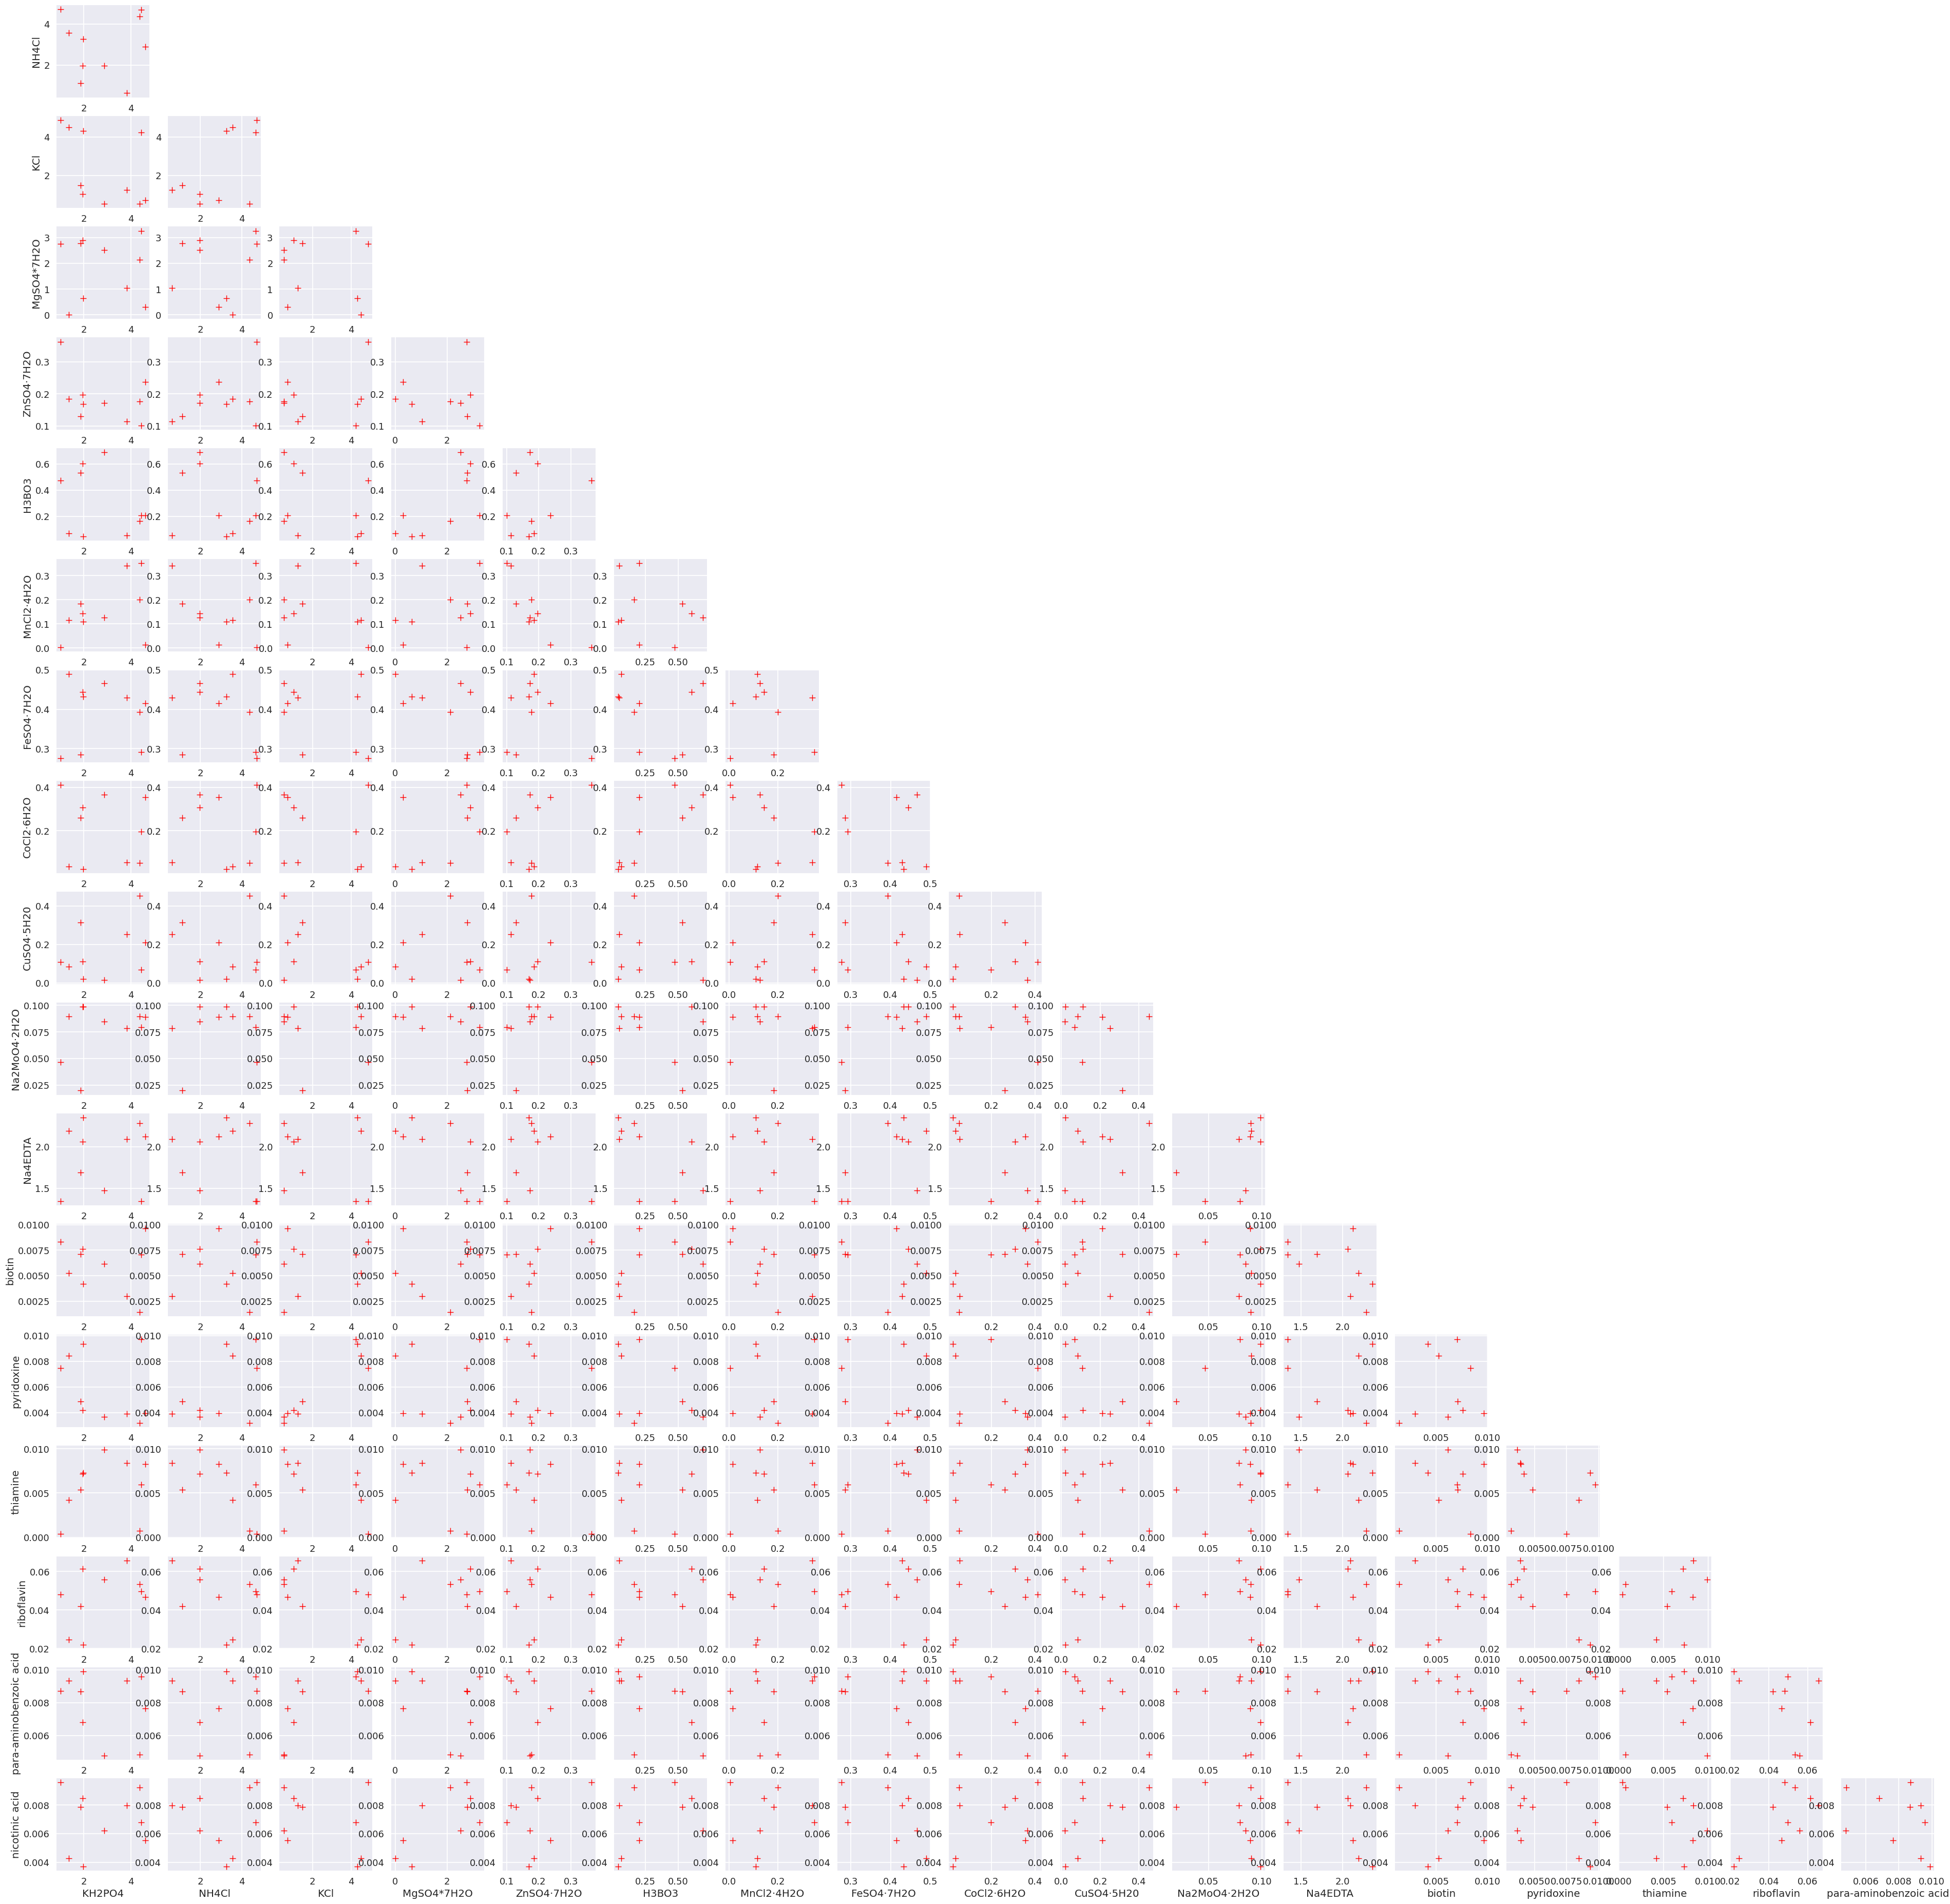

In [28]:
designs_pairwise(art, df_rec_explor)

In [29]:
df_rec = (df_rec_explor.copy())

In [30]:
# df_rec = df_rec.rename(columns={"Malate titer (g/L)": "Malate titer (g/L) prediction"})


# Check the distribution of designs

Define dataframe with train data and predictions:


In [31]:
df_train = DBTL_results[user_params['components']]
df_train['Malate Titer (g/L)'] = DBTL_results['Malate Titer (g/L)']



Add predictions, cv-predictions and standard deviation of the OD340 predictions:


In [32]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )


In [33]:
df_train['Malate_pred'] = train_predicted_mean
df_train['Malate_std'] = train_predicted_std
df_train['Malate_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['Malate_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]

Add label for control lines:

In [34]:

df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Ingrediant")
df_train['Label'] = 'train'
# df_train.loc[control_lines.index, 'Label'] = 'standard'



In [35]:
df_train

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate_pred,Malate_std,Malate_cv_pred,Malate_cv_std,Label
0,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.003923,0.029026,0.004538,0.002338,2.38,2.047433,2.338671,0.807407,2.953653,train
1,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.003923,0.029026,0.004538,0.002338,2.43,2.047433,2.338671,0.807407,2.953653,train
2,3.980770,2.726696,3.101909,3.564820,0.342065,0.266442,0.266025,0.148381,0.168819,0.217547,...,0.003923,0.029026,0.004538,0.002338,2.49,2.047433,2.338671,0.807407,2.953653,train
3,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,...,0.003438,0.000026,0.007167,0.007175,0.07,0.188970,2.337816,0.241957,3.207608,train
4,0.463416,1.202824,3.487949,2.090830,0.002133,0.641487,0.364212,0.470553,0.419028,0.001260,...,0.003438,0.000026,0.007167,0.007175,0.07,0.188970,2.337816,0.241957,3.207608,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,0.487628,...,0.003318,0.018708,0.001813,0.006659,0.00,0.422449,2.346879,0.201489,2.541215,train
257,4.619793,3.180391,3.814341,0.280609,0.237304,0.879325,0.435048,0.354152,0.088065,0.487628,...,0.003318,0.018708,0.001813,0.006659,0.00,0.422449,2.346879,0.201489,2.541215,train
258,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,0.361906,...,0.002309,0.044397,0.006925,0.005050,0.00,1.141167,2.348676,1.815845,2.972732,train
259,4.291071,4.091897,1.321019,0.299799,0.411875,0.080135,0.468360,0.114329,0.357079,0.361906,...,0.002309,0.044397,0.006925,0.005050,0.00,1.141167,2.348676,1.815845,2.972732,train


save the control data set for this cycle:

In [36]:


file = f"{user_params['output_file_path']}/train_pred.csv"
df_train.to_csv(file)



In [37]:
# df_stand.values.T[:,3]

In [38]:
df_train.loc[78,:]

KH2PO4                    4.087562
NH4Cl                     2.131518
KCl                        2.83772
MgSO4*7H2O                2.355412
ZnSO4·7H2O                0.425586
H3BO3                     1.040215
MnCl2·4H2O                0.005711
FeSO4·7H2O                0.002432
CoCl2·6H2O                0.134524
CuSO4·5H20                0.388366
Na2MoO4·2H2O              0.077741
Na4EDTA                   2.260173
biotin                    0.007791
pyridoxine                0.000308
thiamine                  0.004017
riboflavin                0.001244
para-aminobenzoic acid    0.000074
nicotinic acid            0.000081
Malate Titer (g/L)             0.0
Malate_pred               0.078924
Malate_std                  2.3379
Malate_cv_pred            2.316371
Malate_cv_std             2.972307
Label                        train
Name: 78, dtype: object

In [39]:
X_train = df_train[user_params['components']].values
X_train[77,:]

array([1.50e+00, 1.43e+00, 5.00e-01, 5.00e-01, 2.25e-03, 1.10e-02,
       5.00e-03, 5.00e-03, 1.70e-03, 1.60e-03, 8.50e-05, 5.00e-03,
       1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04])

In [40]:
def designs_pairwise(art, df_rec, user_params, df_stand, df_train=None):

    dim = art.num_input_var

    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(35, 35))
    fig.patch.set_facecolor("white")

    X = df_rec[user_params['components']].values
    X_train = df_train[user_params['components']].values
    standard = df_stand.values.T

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            ax.scatter(
                X_train[:, var1],
                X_train[:, var2],
                c="r",
                marker=".",
                s=150*df_train['Malate Titer (g/L)'],
                lw=1,
                label="Train data",
            )
            
#             ax.scatter(
#                 standard[:, var1],
#                 standard[:, var2],
#                 c="k",
#                 marker=".",
#                 s=150*standard[:, -1].astype(float),
#                 lw=1,
#                 label="Standard",
#             )
            
            ax.scatter(
                X[:, var1],
                X[:, var2],
                c="g",
                marker=".",
                s=150*df_rec['Malate Titer (g/L) mean'],
                lw=1,
                label="Recommendations",
            )
            
            ax.scatter(
                X_train[77, var1],
                X_train[77, var2],
                c="k",
                marker=".",
                s=150*df_rec['Malate Titer (g/L) mean'].values[-1],
                lw=1,
                label="Standard",
            )
            
            
                        
            if var2 == (dim - 1):
                ax.set_xlabel(art.input_vars[var1])
            if var1 == 0:
                ax.set_ylabel(art.input_vars[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

                    
    fig.savefig(
        f'{art.outDir}/designs_pairwise_26.png',
        bbox_inches="tight",
        transparent=False, 
        dpi=300
    )



Red are train data, green are recommendations, black are standards


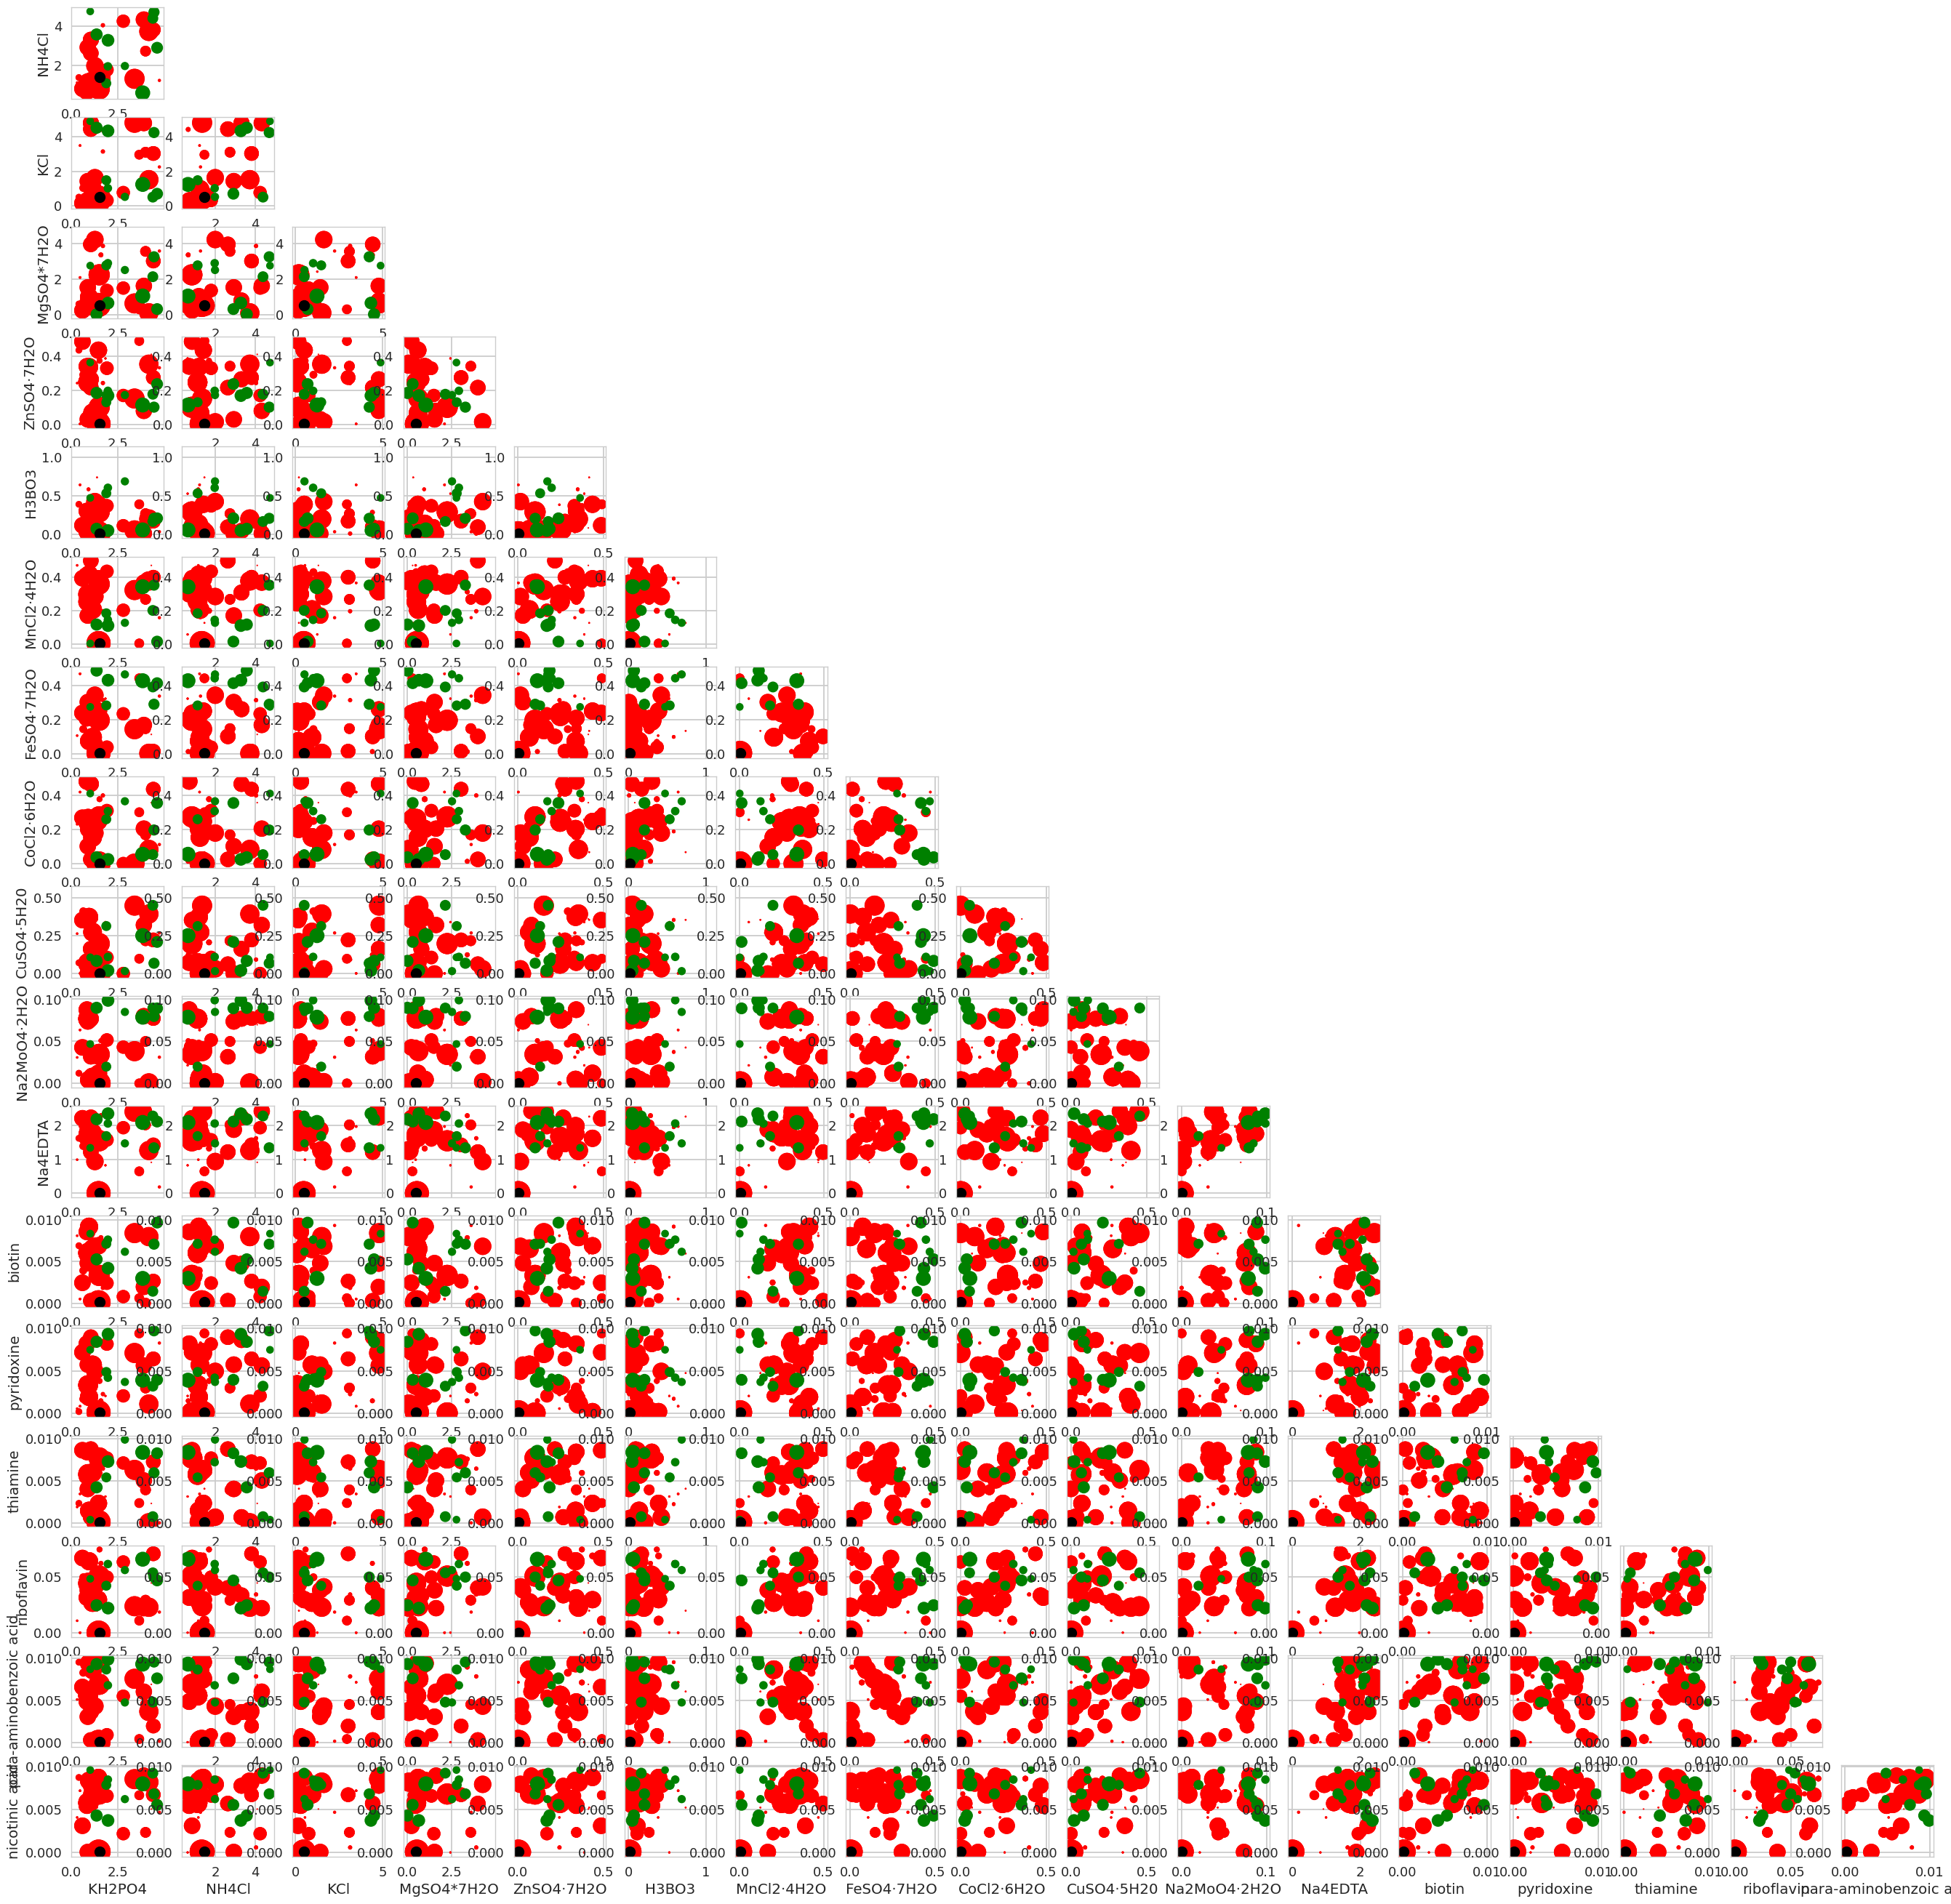

In [41]:
designs_pairwise(art, df_rec, user_params, df_stand,df_train)

In [42]:
df_rec

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,3.828675,0.621465,1.240994,1.041451,0.113488,0.054703,0.341223,0.429727,0.054993,0.251498,...,0.002969,0.003889,0.008375,0.065605,0.009325,0.007980,5.112985,5.112985,2.406545,exploration
1,1.872974,1.103961,1.484179,2.775847,0.129709,0.532009,0.182700,0.284566,0.260027,0.314928,...,0.007108,0.004857,0.005402,0.041946,0.008686,0.007852,2.110124,2.110124,2.399036,exploration
2,2.871420,1.975759,0.523162,2.511222,0.171924,0.687266,0.126149,0.466855,0.365200,0.016180,...,0.006157,0.003679,0.009884,0.055900,0.004774,0.006202,1.366781,1.366781,2.389498,exploration
3,4.602384,2.896720,0.703066,0.303343,0.236912,0.205924,0.014042,0.415415,0.355167,0.209686,...,0.009649,0.003933,0.008269,0.046671,0.007640,0.005537,3.063016,3.063016,2.388037,exploration
4,1.958004,1.959630,1.019778,2.897484,0.196985,0.603512,0.143532,0.444478,0.307528,0.110614,...,0.007607,0.004181,0.007204,0.061299,0.006812,0.008468,1.467233,1.467233,2.387376,exploration
5,1.965494,3.273739,4.333824,0.645869,0.168718,0.046540,0.109407,0.432857,0.025236,0.020338,...,0.004187,0.009322,0.007283,0.021963,0.009891,0.003722,3.557785,3.557785,2.364728,exploration
6,4.372539,4.381191,0.506900,2.133481,0.176888,0.164310,0.199915,0.393089,0.053136,0.452417,...,0.001426,0.003180,0.000741,0.053451,0.004816,0.009219,2.535037,2.535037,2.360834,exploration
7,1.009964,4.731832,4.890619,2.759800,0.363581,0.471889,0.002918,0.276033,0.410649,0.107661,...,0.008326,0.007475,0.000381,0.048153,0.008718,0.009584,1.186013,1.186013,2.360781,exploration
8,1.351364,3.567268,4.515219,0.005451,0.184499,0.068868,0.115610,0.489477,0.037269,0.084061,...,0.005245,0.008421,0.004221,0.024498,0.009328,0.004288,3.253610,3.253610,2.359398,exploration
9,4.433752,4.694351,4.238639,3.260032,0.100750,0.205516,0.350869,0.291598,0.197136,0.068449,...,0.007067,0.009720,0.005948,0.049676,0.009575,0.006807,2.684709,2.684709,2.358010,exploration



## Saving the generated designs

include all replicates:

In [43]:
df_rec_wells = df_rec.loc[df_rec.index.repeat(3)]

In [44]:
df_rec_wells

,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
0,3.828675,0.621465,1.240994,1.041451,0.113488,0.054703,0.341223,0.429727,0.054993,0.251498,...,0.002969,0.003889,0.008375,0.065605,0.009325,0.007980,5.112985,5.112985,2.406545,exploration
0,3.828675,0.621465,1.240994,1.041451,0.113488,0.054703,0.341223,0.429727,0.054993,0.251498,...,0.002969,0.003889,0.008375,0.065605,0.009325,0.007980,5.112985,5.112985,2.406545,exploration
0,3.828675,0.621465,1.240994,1.041451,0.113488,0.054703,0.341223,0.429727,0.054993,0.251498,...,0.002969,0.003889,0.008375,0.065605,0.009325,0.007980,5.112985,5.112985,2.406545,exploration
1,1.872974,1.103961,1.484179,2.775847,0.129709,0.532009,0.182700,0.284566,0.260027,0.314928,...,0.007108,0.004857,0.005402,0.041946,0.008686,0.007852,2.110124,2.110124,2.399036,exploration
1,1.872974,1.103961,1.484179,2.775847,0.129709,0.532009,0.182700,0.284566,0.260027,0.314928,...,0.007108,0.004857,0.005402,0.041946,0.008686,0.007852,2.110124,2.110124,2.399036,exploration
1,1.872974,1.103961,1.484179,2.775847,0.129709,0.532009,0.182700,0.284566,0.260027,0.314928,...,0.007108,0.004857,0.005402,0.041946,0.008686,0.007852,2.110124,2.110124,2.399036,exploration
2,2.871420,1.975759,0.523162,2.511222,0.171924,0.687266,0.126149,0.466855,0.365200,0.016180,...,0.006157,0.003679,0.009884,0.055900,0.004774,0.006202,1.366781,1.366781,2.389498,exploration
2,2.871420,1.975759,0.523162,2.511222,0.171924,0.687266,0.126149,0.466855,0.365200,0.016180,...,0.006157,0.003679,0.009884,0.055900,0.004774,0.006202,1.366781,1.366781,2.389498,exploration
2,2.871420,1.975759,0.523162,2.511222,0.171924,0.687266,0.126149,0.466855,0.365200,0.016180,...,0.006157,0.003679,0.009884,0.055900,0.004774,0.006202,1.366781,1.366781,2.389498,exploration
3,4.602384,2.896720,0.703066,0.303343,0.236912,0.205924,0.014042,0.415415,0.355167,0.209686,...,0.009649,0.003933,0.008269,0.046671,0.007640,0.005537,3.063016,3.063016,2.388037,exploration




Rename index to well names:


In [45]:
well_rows = 'ABCDEFGHIJ'
well_columns = '123'


In [46]:
well_names = [f'{row}{column}'  for row in well_rows for column in well_columns ]

df_rec_wells['Well'] = well_names
df_rec_wells = df_rec_wells.set_index(['Well'])
df_rec_wells


,KH2PO4,NH4Cl,KCl,MgSO4*7H2O,ZnSO4·7H2O,H3BO3,MnCl2·4H2O,FeSO4·7H2O,CoCl2·6H2O,CuSO4·5H20,...,biotin,pyridoxine,thiamine,riboflavin,para-aminobenzoic acid,nicotinic acid,Malate Titer (g/L),Malate Titer (g/L) mean,Malate Titer (g/L) std,Label
Well,,,,,,,,,,,,,,,,,,,,,
A1,3.828675,0.621465,1.240994,1.041451,0.113488,0.054703,0.341223,0.429727,0.054993,0.251498,...,0.002969,0.003889,0.008375,0.065605,0.009325,0.007980,5.112985,5.112985,2.406545,exploration
A2,3.828675,0.621465,1.240994,1.041451,0.113488,0.054703,0.341223,0.429727,0.054993,0.251498,...,0.002969,0.003889,0.008375,0.065605,0.009325,0.007980,5.112985,5.112985,2.406545,exploration
A3,3.828675,0.621465,1.240994,1.041451,0.113488,0.054703,0.341223,0.429727,0.054993,0.251498,...,0.002969,0.003889,0.008375,0.065605,0.009325,0.007980,5.112985,5.112985,2.406545,exploration
B1,1.872974,1.103961,1.484179,2.775847,0.129709,0.532009,0.182700,0.284566,0.260027,0.314928,...,0.007108,0.004857,0.005402,0.041946,0.008686,0.007852,2.110124,2.110124,2.399036,exploration
B2,1.872974,1.103961,1.484179,2.775847,0.129709,0.532009,0.182700,0.284566,0.260027,0.314928,...,0.007108,0.004857,0.005402,0.041946,0.008686,0.007852,2.110124,2.110124,2.399036,exploration
B3,1.872974,1.103961,1.484179,2.775847,0.129709,0.532009,0.182700,0.284566,0.260027,0.314928,...,0.007108,0.004857,0.005402,0.041946,0.008686,0.007852,2.110124,2.110124,2.399036,exploration
C1,2.871420,1.975759,0.523162,2.511222,0.171924,0.687266,0.126149,0.466855,0.365200,0.016180,...,0.006157,0.003679,0.009884,0.055900,0.004774,0.006202,1.366781,1.366781,2.389498,exploration
C2,2.871420,1.975759,0.523162,2.511222,0.171924,0.687266,0.126149,0.466855,0.365200,0.016180,...,0.006157,0.003679,0.009884,0.055900,0.004774,0.006202,1.366781,1.366781,2.389498,exploration
C3,2.871420,1.975759,0.523162,2.511222,0.171924,0.687266,0.126149,0.466855,0.365200,0.016180,...,0.006157,0.003679,0.009884,0.055900,0.004774,0.006202,1.366781,1.366781,2.389498,exploration


In [47]:
file = f"{user_params['output_file_path']}/target_concentrations_26.csv"
df_rec.to_csv(file) # This file will be used for the computation of volume transfers and data analysis
file = f"{user_params['output_file_path']}/target_concentrations_wells_26.csv"

df_rec_wells.to_csv(file) # This file will be used for the computation of volume transfers and data analysis
